In [1]:
from PIL import Image
from PIL.ImageOps import expand

import torch
import numpy as np

from transformers import pipeline
from diffusers import KandinskyV22PriorPipeline, KandinskyV22ControlnetImg2ImgPipeline
from diffusers.utils import make_image_grid

from utils import *

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
depth_estimator = pipeline("depth-estimation")

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

In [2]:
img = resize_store_ratio(Image.open("./image/outpaint/blue.jpg")).resize((768, 512))
img = img.resize((round(cur/64) * 64 for cur in img.size))
width, height = img.size

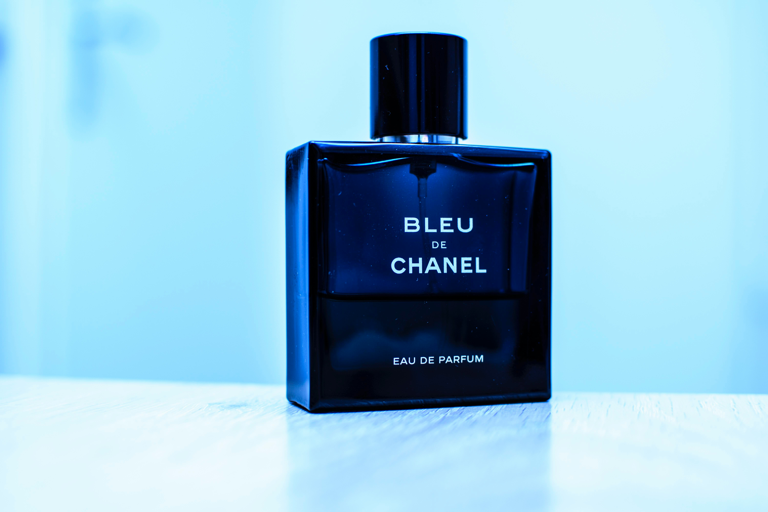

In [3]:
img

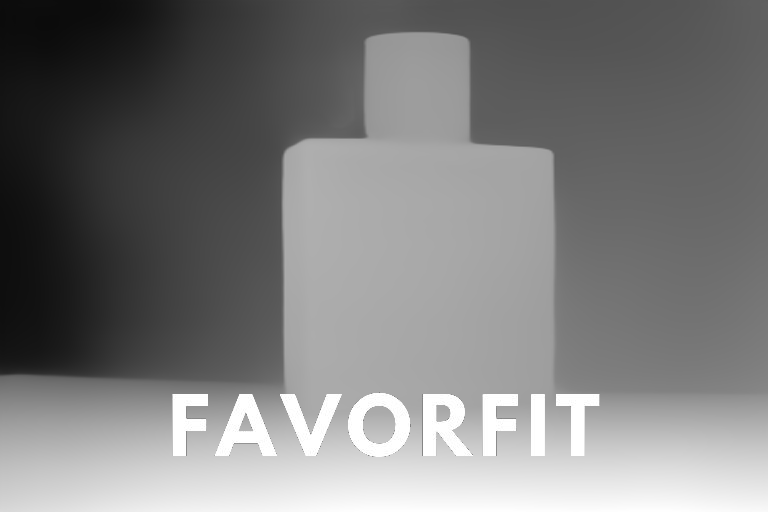

In [41]:
mask = Image.open("/home/mlfavorfit/Downloads/Fav (2).jpg")
dilate_mask = Image.fromarray(cv2.dilate(np.array(mask), np.ones((3,3)), iterations=10))
small_dilate_mask = Image.fromarray(cv2.dilate(np.array(mask), np.ones((3,3)), iterations=3))
depth = depth_estimator(img)["depth"].convert("RGB")

import numpy as np
new_depth = Image.fromarray(np.where(np.array(mask) < 127, np.array(depth), np.array(mask)))
new_depth

In [5]:
from PIL.ImageOps import invert

In [54]:
import torch
from diffusers import StableDiffusionControlNetInpaintPipeline, StableDiffusionControlNetImg2ImgPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from PIL import Image

from IPAdapter.ip_adapter import IPAdapter

In [10]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "./IPAdapter/models/image_encoder/"
ip_ckpt = "./IPAdapter/models/ip-adapter_sd15.bin"
device = "cuda"

In [11]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [55]:
# load controlnet
controlnet_model_path = "lllyasviel/control_v11f1p_sd15_depth"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [56]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [57]:
style_image = img
# style_image = Image.open("./image/outpaint/black.jpg")

In [79]:
# generate image variations
images = ip_model.generate(
    pil_image=style_image,
                           image=img, 
                        #    mask_image=dilate_mask,
                           control_image=new_depth,
                           num_samples=1,
                           num_inference_steps=30, 
                           seed=43,
                           strength=0.9,
                           guidance_scale=7.5,
                           controlnet_conditioning_scale=1.2,
                           control_guidance_end=1.0,
                           scale=1.0)

AttributeError: 'NoneType' object has no attribute 'size'

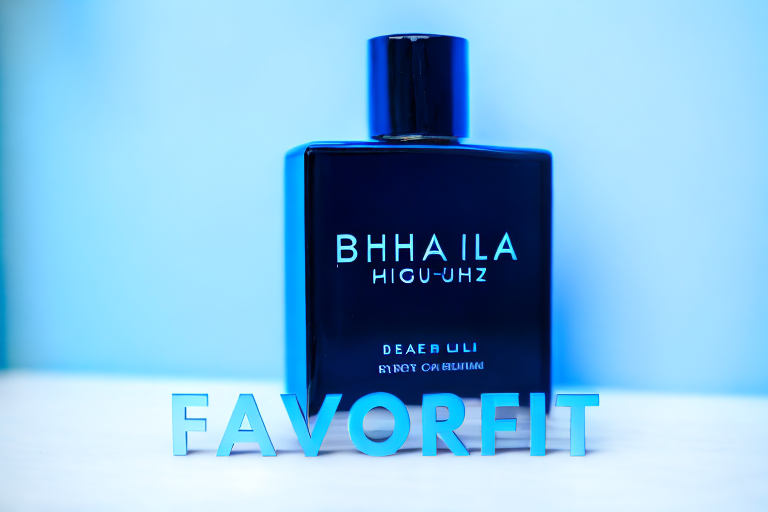

In [73]:
make_image_grid(images, 1, 1)

In [75]:
output_image = images[0]

In [1]:
import torch
import os
import random
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from diffusers import DDPMScheduler, UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_inpainting_split import KandinskyV22ControlnetInpaintPipeline

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-inpainting-controlnet-split"
priot_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"

In [3]:
movq = VQModel.from_pretrained(
            decoder_model_path, subfolder="movq", torch_dtype=torch.float16
        ).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    priot_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()
controlnet = ControlNetModel.from_pretrained(decoder_model_path, subfolder="controlnet/canny")

The config attributes {'center_input_sample': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [4]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        priot_model_path,
        image_encoder=image_encoder,
        use_safetensors=True,
        torch_dtype=torch.float16,
    )

pipeline = KandinskyV22ControlnetInpaintPipeline.from_pretrained(
        decoder_model_path,
        unet=unet,
        movq=movq,
        controlnet=controlnet,
        torch_dtype=torch.float16,
    )

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  9.77it/s]
The config attributes {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} were passed to KandinskyV22ControlnetInpaintPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} are not expected by KandinskyV22ControlnetInpaintPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 625.83it/s]


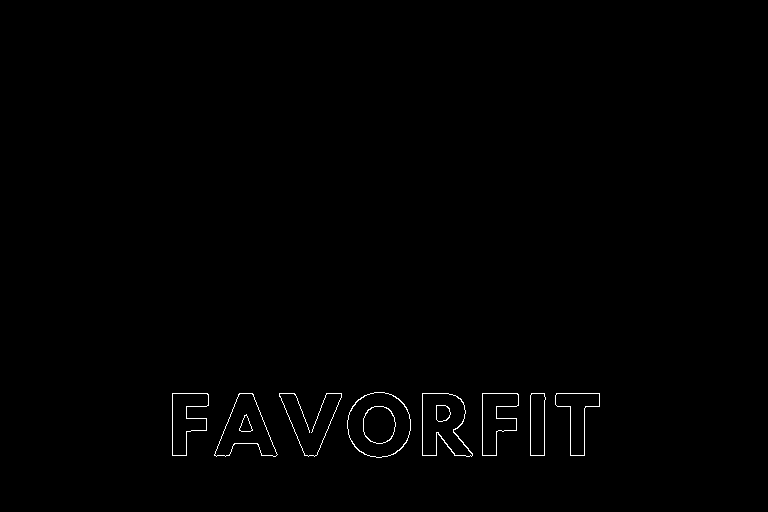

In [22]:
from utils import *

img = resize_store_ratio(Image.open("./image/outpaint/blue.jpg")).resize((768, 512))
img = img.resize((round(cur/64) * 64 for cur in img.size))
width, height = img.size

mask = Image.open("/home/mlfavorfit/Downloads/Fav (2).jpg")
dilated_mask = Image.fromarray(cv2.dilate(np.array(mask), np.ones((3,3)), iterations=10))
small_dilate_mask = Image.fromarray(cv2.dilate(np.array(mask), np.ones((3,3)), iterations=3))

canny = make_canny_condition(mask)
canny

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:06<00:00,  8.26it/s]


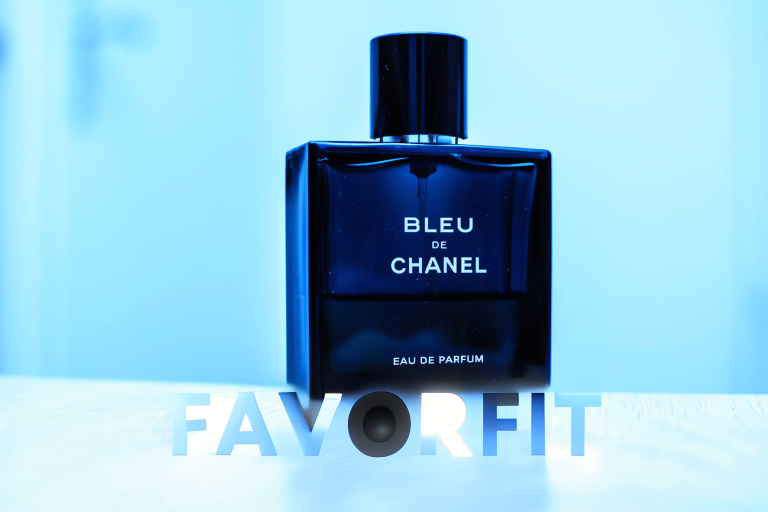

In [61]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

prompt = "blue, text"
negative_prior_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

generator = torch.Generator(device="cuda").manual_seed(42)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
    )

    output_image = pipeline(image=img,
                            mask_image=dilated_mask,
                            control_image=canny,
                            **prior_output,
                            height=height,
                            width=width,
                            num_inference_steps=50,
                            strength=1.0,
                            guidance_scale=4.5,
                            controlnet_scale=2.0,
                            generator=generator).images[0]

output_image

In [1]:
import torch
from diffusers import StableDiffusionXLControlNetInpaintPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel
from PIL import Image

from IPAdapter.ip_adapter import IPAdapterPlusXL

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model_path = "/home/mlfavorfit/.cache/huggingface/hub/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/76d28af79639c28a79fa5c6c6468febd3490a37e"
image_encoder_path = "./IPAdapter/sdxl_models/image_encoder"
ip_ckpt = "./IPAdapter/sdxl_models/ip-adapter_sdxl_vit-h.bin"
device = "cuda"

In [3]:
# load controlnet
controlnet_model_path = "diffusers/controlnet-depth-sdxl-1.0"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)

# load SD pipeline
pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    feature_extractor=None,
    safety_checker=None
)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetInpaintPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


In [4]:
# load ip-adapter
ip_model = IPAdapterPlusXL(pipe, image_encoder_path, ip_ckpt, device)

RuntimeError: Error(s) in loading state_dict for Resampler:
	Missing key(s) in state_dict: "latents", "proj_in.weight", "proj_in.bias", "proj_out.weight", "proj_out.bias", "norm_out.weight", "norm_out.bias", "layers.0.0.norm1.weight", "layers.0.0.norm1.bias", "layers.0.0.norm2.weight", "layers.0.0.norm2.bias", "layers.0.0.to_q.weight", "layers.0.0.to_kv.weight", "layers.0.0.to_out.weight", "layers.0.1.0.weight", "layers.0.1.0.bias", "layers.0.1.1.weight", "layers.0.1.3.weight", "layers.1.0.norm1.weight", "layers.1.0.norm1.bias", "layers.1.0.norm2.weight", "layers.1.0.norm2.bias", "layers.1.0.to_q.weight", "layers.1.0.to_kv.weight", "layers.1.0.to_out.weight", "layers.1.1.0.weight", "layers.1.1.0.bias", "layers.1.1.1.weight", "layers.1.1.3.weight", "layers.2.0.norm1.weight", "layers.2.0.norm1.bias", "layers.2.0.norm2.weight", "layers.2.0.norm2.bias", "layers.2.0.to_q.weight", "layers.2.0.to_kv.weight", "layers.2.0.to_out.weight", "layers.2.1.0.weight", "layers.2.1.0.bias", "layers.2.1.1.weight", "layers.2.1.3.weight", "layers.3.0.norm1.weight", "layers.3.0.norm1.bias", "layers.3.0.norm2.weight", "layers.3.0.norm2.bias", "layers.3.0.to_q.weight", "layers.3.0.to_kv.weight", "layers.3.0.to_out.weight", "layers.3.1.0.weight", "layers.3.1.0.bias", "layers.3.1.1.weight", "layers.3.1.3.weight". 
	Unexpected key(s) in state_dict: "proj.weight", "proj.bias", "norm.weight", "norm.bias". 

In [ ]:
# generate image variations
images = ip_model.generate(pil_image=style_image,
                           image=img,
                           mask_image=dilated_mask,
                           control_image=mask,
                           num_samples=4,
                           num_inference_steps=50,
                           seed=43,
                           strength=0.95,
                           guidance_scale=4.5,
                           controlnet_conditioning_scale=1.2,
                           control_guidance_end=1.0,
                           scale=1.0)